# Optimizing Coursera Portfolio for Engagement & Revenue

This document provides an in-depth analysis of Coursera’s course portfolio, using data on course features, enrollment, and ratings. In the competitive online education space, understanding what drives learner engagement and satisfaction is key to sustained growth.

## Goal of the Analysis

Identify course characteristics most strongly linked to **higher student enrollment and better ratings** on Coursera.

### Key Questions

To achieve this goal, the analysis seeks to answer the following questions:   

1. Which course characteristics *(such as difficulty level, certificate type, the offering organization/institution, or inferred topics from course titles)* demonstrate the strongest correlation with both high student enrollment and ratings?

2. How can Coursera effectively leverage these identified insights to prioritize future course development initiatives, optimize existing course content, and refine marketing strategies to maximize student acquisition and retention?

### Scope and Methodology

This analysis begins with thorough data cleaning and preprocessing to ensure quality and consistency, followed by exploratory data analysis (EDA) to uncover patterns, relationships, and outliers in course performance. The insights will inform strategic, data-driven recommendations to optimize Coursera’s course portfolio and support platform growth. 

Table of Contents:

1. Load & Display Data
2. Data Cleaning & Preparation for Analysis
3. Exploratory Data Analysis
4. Correlation Analysis
5. Statistical Test
6. Insights & Recommendations

### Key Insights

- The most successful courses on Coursera are typically beginner or mixed-level, offered by reputable institutions, and focused on high-demand technical skills.

| **Insights** | **Recommendations** |
|--------------|----------------------|
| **1. High Course Quality**: Coursera courses maintain an average rating of **4.677** with a low standard deviation, showing consistent learner satisfaction. | **Promote Top-Rated Courses**: Launch campaigns highlighting highly rated courses (4.8+), even if enrollments are currently low, to boost visibility through quality signals. |
| **2. Uneven Enrollment Distribution**: A few top-performing courses (right-skewed distribution) dominate overall enrollments. | **Course Portfolio Optimization**: Review and refresh low-enrollment courses based on ratings. Reallocate resources toward high-impact content. |
| **3. "Mixed" Difficulty Courses Excel**: Courses labeled "Mixed" (e.g., *The Science of Well-Being*, *Machine Learning*) combine wide appeal with high ratings. | **Analyze Successful "Mixed" Courses**: Study top "Mixed" courses to identify repeatable formats and apply lessons to design future offerings. |
| **4. Beginner Courses Drive Volume**: Entry-level courses in high-demand areas (e.g., Python, IT Support) attract massive enrollments. | **Expand Beginner Offerings in Key Areas**: Develop more beginner-level courses in tech fields like AI, cybersecurity, and cloud computing. |
| **5. Brand Reputation Matters**: Top enrollments cluster around prestigious universities and companies, underscoring brand trust. | **Leverage Strategic Partnerships**: Strengthen collaborations with top-tier academic and industry partners. Consider co-branded content. |
| **6. High-Demand Content Categories**: Fields like *Data Science*, *Programming*, and *Health* dominate in popularity and relevance. | **Targeted Content Expansion**: Invest in growing high-demand categories and explore emerging trends within those verticals. |

**Next Steps considering broader data:**
- Conduct a deeper analysis of course descriptions and content to move beyond keyword matching.
- Explore the relationship between course length, price, and enrollment.
- Analyze learner demographics to better understand the audience for different course types.

### Dataset

Data originally scrapped from Coursera website, taken from [Kaggle](https://www.kaggle.com/datasets/siddharthm1698/coursera-course-dataset).  
It consists of **890 courses and 6 columns**. Description of each column:

1. ***course_title*** : The title of the course.
2. ***course_organization*** : The organization offering the course.
3. ***course_Certificate_type*** : The type of certificate available upon course completion.
4. ***course_rating*** : The average user rating for the course.
5. ***course_difficulty*** : The difficulty level of the course.
6. ***course_students_enrolled*** : The number of students enrolled in the course.

---

### Import

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Statistics & modeling
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

# Machine learning and processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Language detection and translation
from langdetect import detect, detect_langs
from deep_translator import GoogleTranslator
import langid

# Utilities
import re
import itertools

---

## 1. Load & Display Data

In [2]:
df_origin = pd.read_csv("coursera/coursera.csv", index_col=0).sort_index()
df_origin.head()

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
0,IBM Data Science,IBM,PROFESSIONAL CERTIFICATE,4.6,Beginner,480k
1,Introduction to Data Science,IBM,SPECIALIZATION,4.6,Beginner,310k
2,The Science of Well-Being,Yale University,COURSE,4.9,Mixed,2.5m
3,Python for Everybody,University of Michigan,SPECIALIZATION,4.8,Beginner,1.5m
4,Google IT Support,Google,PROFESSIONAL CERTIFICATE,4.8,Beginner,350k


#### 1.1. Rename Columns
- Remove the "course_" prefix from column names (except *"course_title"*).
- Convert all column names to lowercase for consistency and easier access in code.

In [3]:
df = df_origin.copy()

In [4]:
cols = df.columns.tolist()
new_cols = [cols[0]] + [col.replace("course_", "").lower() for col in cols[1:]]

df.columns = new_cols

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_title       891 non-null    object 
 1   organization       891 non-null    object 
 2   certificate_type   891 non-null    object 
 3   rating             891 non-null    float64
 4   difficulty         891 non-null    object 
 5   students_enrolled  891 non-null    object 
dtypes: float64(1), object(5)
memory usage: 48.7+ KB


All columns contain non-null values, but most of their data types should be updated for better performance and clarity:

- *course_title*, *organization*: convert to string
- *certificate_type*, *difficulty*: convert to category
- *students_enrolled*: convert to int

#### 1.2. Convert data types

In [6]:
# Apply title casing for consistency
df["certificate_type"] = df["certificate_type"].str.title()

In [7]:
dtype_mapping = {
    "course_title": "string",
    "organization": "string",
    "certificate_type": "category",
    "difficulty": "category"
}

for col, dtype in dtype_mapping.items():
    df[col] = df[col].astype(dtype)

Change ***'course_students_enrolled'*** to Int64:

In [8]:
def convert_enrollment_to_int(df, column_name):
    """
    Converts column with student enrollment figures 
    (e.g., "690k", "1.m") into integer numbers.
    """
    def parse_enrollment_string(enrollment_str):
        if pd.isna(enrollment_str):
            return None
        if isinstance(enrollment_str, (int, float)):
            return int(enrollment_str)

        s = str(enrollment_str).strip().lower().replace(",", "")
        if "k" in s:
            return int(float(s.replace("k", "")) * 1000)
        elif "m" in s:
            return int(float(s.replace("m", "")) * 1000000)
        else:
            try:
                return int(float(s))
            except ValueError:
                return None

    df[column_name] = df[column_name].apply(parse_enrollment_string)
    df[column_name] = df[column_name].astype("Int64")

    return df

In [9]:
df = convert_enrollment_to_int(df, "students_enrolled")

In [10]:
df.head()

,course_title,organization,certificate_type,rating,difficulty,students_enrolled
0,IBM Data Science,IBM,Professional Certificate,4.6,Beginner,480000
1,Introduction to Data Science,IBM,Specialization,4.6,Beginner,310000
2,The Science of Well-Being,Yale University,Course,4.9,Mixed,2500000
3,Python for Everybody,University of Michigan,Specialization,4.8,Beginner,1500000
4,Google IT Support,Google,Professional Certificate,4.8,Beginner,350000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   course_title       891 non-null    string  
 1   organization       891 non-null    string  
 2   certificate_type   891 non-null    category
 3   rating             891 non-null    float64 
 4   difficulty         891 non-null    category
 5   students_enrolled  891 non-null    Int64   
dtypes: Int64(1), category(2), float64(1), string(2)
memory usage: 37.7 KB


---

## 2. Data Cleaning & Preparation for Analysis

#### 2.1. Check for duplicate rows

In [12]:
duplicates = df[df.duplicated()]
print(f"Found {len(duplicates)} duplicate rows.")

Found 0 duplicate rows.


---

#### 2.2. Check unique column values

In [13]:
df.nunique()

course_title         888
organization         154
certificate_type       3
rating                14
difficulty             4
students_enrolled    205
dtype: int64

---

#### 2.3. Languages and translation

The implementation of language detection and translation for ***'course_title'*** allows for a more comprehensive analysis across all courses, regardless of their original language.

##### 2.3.1. Detect and Assign the Language

In [14]:
df_lang = df.copy()

# Returns the language code like 'en', 'ru', etc.
def detect_lang(text):
    return langid.classify(text)[0]  

In [15]:
df_lang["language"] = df_lang["course_title"].apply(detect_lang)

In [16]:
df_lang.tail()

,course_title,organization,certificate_type,rating,difficulty,students_enrolled,language
886,Understanding Modern Finance,American Institute of Business and Economics,Specialization,4.4,Intermediate,11000,de
887,Object-Oriented Design,University of Alberta,Course,4.7,Intermediate,33000,en
888,Aprende a programar con Python,Universidad Austral,Specialization,4.2,Beginner,6600,es
889,Погружение в Python,Moscow Institute of Physics and Technology,Course,4.7,Intermediate,45000,ru
890,Compassionate Leadership Through Service Learn...,University of Colorado Boulder,Course,4.9,Beginner,6400,en


---

##### 2.3.2. Fix Wrongly Detected Language

Since several course titles were wrongly detected *(e.g. 886: 'language' - de)*, fixed it manually.

In [17]:
# Index-based manual language fixes
manual_index_updates = {
    "en": [5, 6, 14, 21, 33, 95, 149, 181, 
           189, 205, 207, 348, 360, 365, 
           367, 387, 390, 435, 487, 496, 
           537, 578, 601, 632, 676, 682, 
           704, 756, 761, 770, 777, 817, 824],
    "es": [366, 512, 607, 881],
    "ru": [236, 846, 883]
}

for lang, idx_list in manual_index_updates.items():
    df_lang.loc[idx_list, "language"] = lang

# Value-based replacements
replace_languages = {
    "nl": "en", "it": "en", "et": "en",
    "de": "en", "pl": "en", "hu": "en",
    "ro": "en", "zh": "ja"
}

df_lang["language"] = df_lang["language"].replace(replace_languages)

In [18]:
language_counts = df_lang["language"].value_counts().reset_index()
language_counts.columns = ["language", "count"]
non_english_total = df_lang[df_lang["language"] != "en"].shape[0]
print(language_counts)
print("Total non-English courses:", non_english_total)

  language  count
0       en    804
1       es     55
2       ru     16
3       fr      9
4       ja      4
5       pt      3
Total non-English courses: 87


---

##### 2.3.3. Translate non English course titles

In [19]:
def translate_to_english(title, language):
    if lang == "en":
        return title
    try:
        translated = GoogleTranslator(source=language, target="en").translate(title)
        return translated
    except Exception as e:
        print(f"Translation error for '{title}': {e}")
        return title

In [20]:
df_lang["translated_title"] = df_lang.apply(
    lambda row: translate_to_english(row["course_title"], row["language"]), axis=1
)

Translation error for 'Explorando la Energía Sustentable': Explorando la Energía Sustentable --> No translation was found using the current translator. Try another translator?


In [21]:
df_lang.tail()

,course_title,organization,certificate_type,rating,difficulty,students_enrolled,language,translated_title
886,Understanding Modern Finance,American Institute of Business and Economics,Specialization,4.4,Intermediate,11000,en,Understanding Modern Finance
887,Object-Oriented Design,University of Alberta,Course,4.7,Intermediate,33000,en,Object-Oriented Design
888,Aprende a programar con Python,Universidad Austral,Specialization,4.2,Beginner,6600,es,Learn to program with python
889,Погружение в Python,Moscow Institute of Physics and Technology,Course,4.7,Intermediate,45000,ru,Immersion in Python
890,Compassionate Leadership Through Service Learn...,University of Colorado Boulder,Course,4.9,Beginner,6400,en,Compassionate Leadership Through Service Learn...


---

#### 2.4. Create course categories

To better identify the most relevant topics, courses have been categorized by their titles into these groups:
- Data Science & Analytics
- Programming & Software Dev
- Business & Marketing
- Health & Medicine
- Arts & Humanities
- Social Sciences
- Cloud Computing & IT
- Mathematics & Logic
- Personal Development
- Other

⚠️ **Limitation:**
The topic categorization is based solely on keyword matching within course titles. While efficient, this approach may overlook nuances in course content, particularly for ambiguous or multi-topic courses. Future improvements could involve natural language processing on full course descriptions for more accurate classification.

In [22]:
df_coursera = df_lang.copy()

I used **NLTK** for keyword analysis on ***'translated_title'*** to refine categories, presenting only the final keywords for brevity.

In [23]:
def assign_course_category(title):
    """
    Assigns a category to a course title based on predefined keywords.
    """
    title_lower = str(title).lower()

    category_keywords = {
        "Data Science & Analytics": [
            "data science", "data analytics", "data analysis",
            "machine learning", "artificial intelligence",
            "ai", "deep learning", "data", "big data",
            "statistics", "bioinformatics", "sql",
            "analysis", "data visualization",
            "tensorflow", "analytics",
            "information visualization",
        ],
        "Programming & Software Dev": [
            "python", "java", "c++", "c +", "javascript",
            "web development", "programming", "software",
            "app development", "algorithms", "front-end",
            "back-end", "android", "ios", "html", "css",
            "r programming", "php", "swift", "kotlin",
            "web", "agile", "game development", "coding",
            "computer science", "programmer", "robotics",
        ],
        "Business & Marketing": [
            "business", "marketing", "finance", "financial",
            "economics", "management", "entrepreneurship",
            "strategy", "leadership", "accounting",
            "investing", "digital marketing", "sales",
            "hr", "human resources", "advertising",
        ],
        "Health & Medicine": [
            "health", "medicine", "medical", "public health",
            "nutrition", "care", "biology", "anatomy",
            "epidemiology", "genetics", "psychology", "drug",
            "well-being", "nursing", "physiology", "sports",
            "covid", "dentistry", "autism", "cancer", "hospital",
            "dermatology", "immunology",
        ],
        "Arts & Humanities": [
            "art", "history", "literature", "philosophy",
            "music", "design", "writing", "creative",
            "journalism", "ethics", "culture",
        ],
        "Social Sciences": [
            "sociology", "political science", "psychology",
            "human rights", "education", "law", "criminology",
            "politics", "social",
        ],
        "Cloud Computing & IT": [
            "cloud", "aws", "azure", "google cloud", "google",
            "gcp", "it support", "cybersecurity", "cyber",
            "networks", "devops", "system administration",
            "linux", "information technology", "cisco networking",
            "computing",
        ],
        "Mathematics & Logic": [
            "mathematics", "math", "calculus", "algebra",
            "logic", "discrete math",
        ],
        "Personal Development": [
            "learning how to learn", "productivity", "career",
            "personal", "negotiation", "mindset", "communication",
            "language", "russian", "french", "english", "korean",
            "japanese", "spanish", "chinese", "photography", "grammar",
        ],
    }

    for category, keywords in category_keywords.items():
        for keyword in keywords:
            if keyword in title_lower:
                return category
    return "Other"

In [24]:
df_coursera["category"] = df_coursera["translated_title"].apply(assign_course_category)

In [25]:
category_counts = df_coursera["category"].value_counts()
print("Courses per category:")
category_counts

Courses per category:


category
Other                         189
Business & Marketing          182
Data Science & Analytics      180
Programming & Software Dev     80
Health & Medicine              76
Arts & Humanities              72
Cloud Computing & IT           40
Personal Development           38
Social Sciences                29
Mathematics & Logic             5
Name: count, dtype: int64

In [26]:
df_coursera.head()

,course_title,organization,certificate_type,rating,difficulty,students_enrolled,language,translated_title,category
0,IBM Data Science,IBM,Professional Certificate,4.6,Beginner,480000,en,IBM Data Science,Data Science & Analytics
1,Introduction to Data Science,IBM,Specialization,4.6,Beginner,310000,en,Introduction to Data Science,Data Science & Analytics
2,The Science of Well-Being,Yale University,Course,4.9,Mixed,2500000,en,The Science of Well-Being,Health & Medicine
3,Python for Everybody,University of Michigan,Specialization,4.8,Beginner,1500000,en,Python for Everybody,Programming & Software Dev
4,Google IT Support,Google,Professional Certificate,4.8,Beginner,350000,en,Google IT Support,Cloud Computing & IT


---

#### 2.5. Adjust position of the columns

In [27]:
df_coursera = df_coursera[
    [
        "course_title",
        "translated_title",
        "organization",
        "certificate_type",
        "rating",
        "difficulty",
        "students_enrolled",
        "language",
        "category",
    ]
]

In [28]:
df_coursera.head()

,course_title,translated_title,organization,certificate_type,rating,difficulty,students_enrolled,language,category
0,IBM Data Science,IBM Data Science,IBM,Professional Certificate,4.6,Beginner,480000,en,Data Science & Analytics
1,Introduction to Data Science,Introduction to Data Science,IBM,Specialization,4.6,Beginner,310000,en,Data Science & Analytics
2,The Science of Well-Being,The Science of Well-Being,Yale University,Course,4.9,Mixed,2500000,en,Health & Medicine
3,Python for Everybody,Python for Everybody,University of Michigan,Specialization,4.8,Beginner,1500000,en,Programming & Software Dev
4,Google IT Support,Google IT Support,Google,Professional Certificate,4.8,Beginner,350000,en,Cloud Computing & IT


---

#### 2.6.  Assign appropriate data types

In [29]:
dtype_mapping = {
    "translated_title": "string",
    "language": "category",
    "category": "category"
}
for col, dtype in dtype_mapping.items():
    df_coursera[col] = df_coursera[col].astype(dtype)

In [30]:
df_coursera.dtypes

course_title         string[python]
translated_title     string[python]
organization         string[python]
certificate_type           category
rating                      float64
difficulty                 category
students_enrolled             Int64
language                   category
category                   category
dtype: object

---

#### 2.6. Checking for Outliers

In [31]:
# Select only numeric columns
df_numeric = df_coursera.select_dtypes(include=[np.number])

In [32]:
def count_all_outliers(df):
    outlier_dict = {}
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        lower_outliers = (df[col] < lower_bound).sum()
        upper_outliers = (df[col] > upper_bound).sum()

        outlier_dict[col] = {
            "Upper Outliers": upper_outliers,
            "Lower Outliers": lower_outliers  
        }

    outlier_df = pd.DataFrame.from_dict(outlier_dict, orient="index").T
    return outlier_df

In [33]:
outlier_summary_df = count_all_outliers(df_numeric)
outlier_summary_df

,rating,students_enrolled
Upper Outliers,0,78
Lower Outliers,17,0


#### 2.7. Plot the outliers

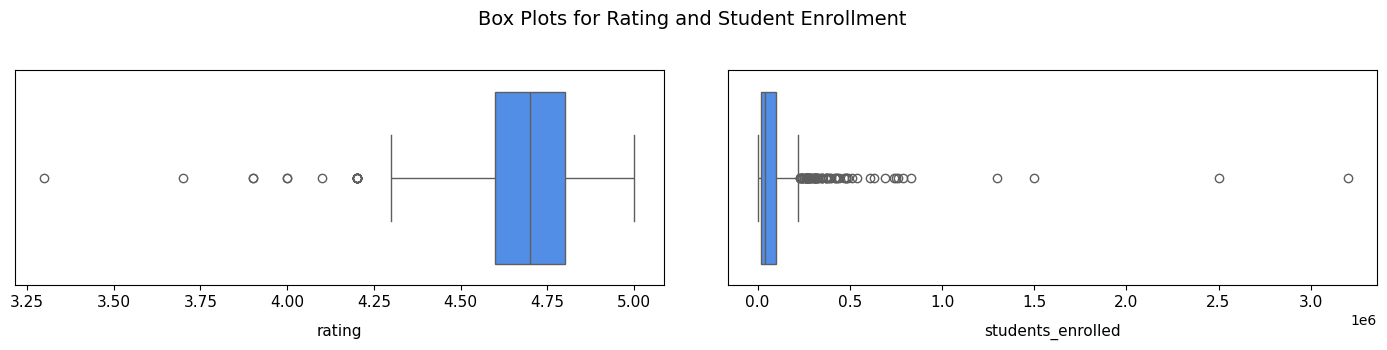

In [34]:
fig, ax = plt.subplots(figsize=(14, 3), nrows=1, ncols=2)

fig.suptitle("Box Plots for Rating and Student Enrollment", fontsize=14, y=1.15)

for i, col in enumerate(df_numeric.columns):
    sns.boxplot(data=df_numeric, x=col, color="#398AFF", ax=ax[i])
    ax[i].set_xlabel(col, fontsize=11, labelpad=10)
    ax[i].tick_params(axis="x", labelsize=11)
    ax[i].set_yticks([])

plt.tight_layout()
fig.subplots_adjust(top=0.95, wspace=0.1)

#### Observations

- The identified outliers in *'rating'* and *'students_enrolled'* are being retained. 
- These values represent important data points within their respective distributions and are crucial for a complete understanding of the dataset, rather than being errors or anomalies that should be removed.

---

## 3. Exploratory Data Analysis

#### Basic Statistics for Numerical Columns

In [35]:
print(df_coursera[["students_enrolled", "rating"]].describe())

       students_enrolled      rating
count              891.0  891.000000
mean        90552.076319    4.677329
std        181936.453852    0.162225
min               1500.0    3.300000
25%              17500.0    4.600000
50%              42000.0    4.700000
75%              99500.0    4.800000
max            3200000.0    5.000000


#### Students Enrolled
- High Variability & Skewness: Enrollments range from 1,500 to 3.2 million.
- The mean (90,552) far exceeds the median (42,000), with a large standard deviation (181,936), indicating a right-skewed distribution: **most courses have low enrollments, while a few attract very high numbers**.

#### Rating
- **High Average Rating (4.68/5)**: Indicates strong overall student satisfaction.
- Low Variability: A small standard deviation (0.16) and narrow range (3.3–5.0) show that most ratings are consistently high.

---

### 3.1. Analysis by **Course**

#### 3.1.1. Top 5 Courses by Enrollment

In [36]:
most_enrolled = df_coursera.sort_values(by="students_enrolled", ascending=False).head()
most_enrolled

,course_title,translated_title,organization,certificate_type,rating,difficulty,students_enrolled,language,category
6,Machine Learning,Machine Learning,Stanford University,Course,4.9,Mixed,3200000,en,Data Science & Analytics
2,The Science of Well-Being,The Science of Well-Being,Yale University,Course,4.9,Mixed,2500000,en,Health & Medicine
3,Python for Everybody,Python for Everybody,University of Michigan,Specialization,4.8,Beginner,1500000,en,Programming & Software Dev
47,Programming for Everybody (Getting Started wit...,Programming for Everybody (Getting Started wit...,University of Michigan,Course,4.8,Mixed,1300000,en,Programming & Software Dev
13,Data Science,Data Science,Johns Hopkins University,Specialization,4.5,Beginner,830000,en,Data Science & Analytics


#### 3.1.2. Bottom 5 Courses by Enrollment

In [37]:
least_enrolled = df_coursera.sort_values(by="students_enrolled").head()
least_enrolled

,course_title,translated_title,organization,certificate_type,rating,difficulty,students_enrolled,language,category
789,El Abogado del Futuro: Legaltech y la Transfor...,The lawyer of the future: legaltech and the di...,Universidad Austral,Course,5.0,Beginner,1500,es,Social Sciences
401,Infectious Disease Modelling,Infectious Disease Modelling,Imperial College London,Specialization,5.0,Intermediate,1600,en,Other
462,Blockchain Revolution in Financial Services,Blockchain Revolution in Financial Services,INSEAD,Specialization,4.6,Beginner,1600,en,Data Science & Analytics
826,The Pronunciation of American English,The Pronunciation of American English,"University of California, Irvine",Specialization,4.6,Beginner,1700,en,Personal Development
373,Healthcare Law,Healthcare Law,University of Pennsylvania,Specialization,4.7,Intermediate,1700,en,Health & Medicine


---

#### 3.1.3. Top and Bottomm Courses by Enrollment Plot

Reusable function to plot the columns based on student enrollment totals:

In [38]:
def plot_enrolled_bar(ax, data, title, column, highlight_index, highlight_color):
    total_enrollment = df_coursera["students_enrolled"].sum()

    bar_colors = ["#AFAFAF"] * len(data)
    bar_colors[highlight_index] = highlight_color

    bars = ax.barh(data[column], data["students_enrolled"], color=bar_colors)

    ax.set_xticks([])
    ax.tick_params(axis="y", labelsize=9, length=0)
    for spine in ax.spines.values():
        spine.set_visible(False)

    for bar in bars:
        width = bar.get_width()
        pct = (width / total_enrollment) * 100

        pct_text = "<0.1%" if pct < 0.1 else f'{pct:.1f}%'

        ax.text(width * 0.95, bar.get_y() + bar.get_height() / 2,
                pct_text, va="center", ha="right",
                color="white", fontsize=8, fontweight="bold")

    ax.set_title(title)
    ax.invert_yaxis()

---

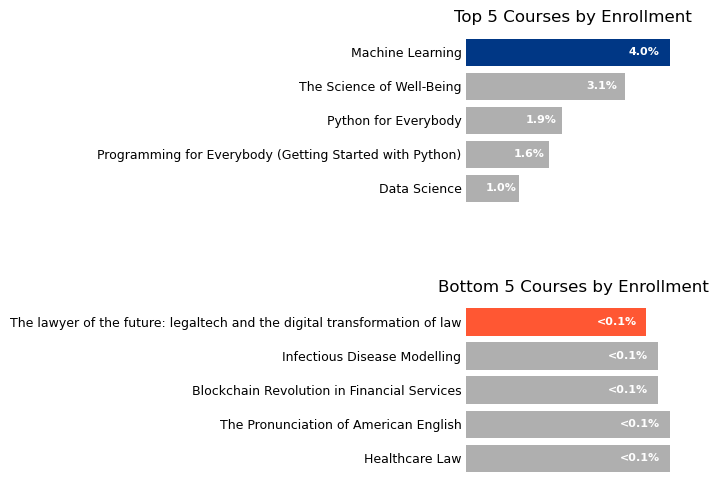

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), gridspec_kw={"height_ratios": [1, 1]})

plot_enrolled_bar(ax1, most_enrolled, "Top 5 Courses by Enrollment", "translated_title", 0, "#003785")
plot_enrolled_bar(ax2, least_enrolled, "Bottom 5 Courses by Enrollment", "translated_title",  0, "#FF5733")

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

#### Insights

- **Technical Courses Dominate**: Machine Learning, Python, and Data Science lead in enrollments, with **Machine Learning** alone accounting for **4% of all enrollments across 891 courses**.
- *The Science of Well-Being* stands out with 3.1% of total enrollments, highlighting its wide popularity.
- The five least enrolled courses are highly niche (e.g., legal or advanced tech), suggesting limited appeal and a more targeted audience.

---

#### 3.1.4. Course Success Score

- Check how enrollment reflected in student rating by combining total enrollments and their ratings

In [40]:
df_course = df_coursera.copy()

In [41]:
scaler = MinMaxScaler()
df_course["normalized_rating"] = scaler.fit_transform(df_course[["rating"]])
df_course["normalized_students_enrolled"] = scaler.fit_transform(
    df_course[["students_enrolled"]]
)

In [42]:
# Create a "Success Score" by adding the normalized values
df_course["success_score"] = (
    df_course["normalized_rating"] + df_course["normalized_students_enrolled"]
)

# Sort the DataFrame by 'success_score' and get the top 10 courses
top_10_courses = (
    df_course.sort_values(by="success_score", ascending=False)
    .head(10)
    .reset_index(drop=True)
)

In [43]:
# Plotly bar chart
fig = px.bar(
    top_10_courses,
    x="success_score",
    y="translated_title",
    orientation="h",
    title="Top 10 Courses by Success Score",
    labels={
        "success_score": "Success Score",
    },
    hover_data={
        "rating": ":.2f",
        "students_enrolled": ":,",
        "success_score": ":.2f"
    },
    color="success_score",
    color_continuous_scale=px.colors.sequential.Viridis
)

fig.update_traces(
    hovertemplate="<b>%{y}</b><br><br>" +
                    "Success Score: %{x:.2f}<br>" +
                    "Rating: %{customdata[0]:.2f}<br>" +
                    "Students Enrolled: %{customdata[1]:,}<extra></extra>",
    customdata=top_10_courses[["rating", "students_enrolled"]].values
)

fig.update_layout(
    title={
        "text": "Top 10 Courses by Success Score",
        "x": 0.5,
        "xanchor": "center"
    },
    yaxis_autorange="reversed",
    yaxis={"title": ''},
    xaxis={"title": "Success Score"},
    coloraxis_showscale=False,
    paper_bgcolor="white",
    plot_bgcolor="white"
)

fig.show()

#### Insights

We can confirm that the courses with the highest enrollment also rank among the top in the success score chart.

- **"Machine Learning"** leads the platform, standing out as the **most enrolled and highest-rated** course overall (Success score: 1.94 out of 2).
- **Python courses dominate the list** — including *Python for Everybody, Programming for Everybody, Neural Networks and Deep Learning, and Python Data Structures* — reinforcing Python’s position as the **most in-demand tech skill on Coursera**.
- "The Science of Well-Being" strong second with a score 1.72 (out of 2), showing that personal development and well-being topics can rival technical courses in popularity and effectiveness.

---

### 3.2. Analysis by **Organization**

#### 3.2.1. Top and Bottom 5 Organizations by Students Enrolled

Reusable function to rank columns based on student enrollment totals:

In [44]:
def get_ranked_by_enrollment(df, column, n, order):
    """
    Returns a ranked DataFrame of top or bottom organizations by total 'students_enrolled'.
    Includes any ties at the nth position. Also adds a column with % of total enrollment.
    """

    def format_percent(value):
        return "<0.01%" if value < 0.01 else f"{value:.2f}%"

    enrollment = df.groupby(column, as_index=False, observed=False)[
        "students_enrolled"
    ].sum()

    total_enrollment = enrollment["students_enrolled"].sum()
    raw_percentages = enrollment["students_enrolled"] / total_enrollment * 100
    enrollment["percent_enrolled"] = raw_percentages.apply(format_percent)

    ascending = True if order == "bottom" else False
    sorted_by_column = enrollment.sort_values(
        by="students_enrolled", ascending=ascending
    )

    if len(sorted_by_column) >= n:
        threshold = sorted_by_column.iloc[n - 1]["students_enrolled"]
    else:
        threshold = sorted_by_column.iloc[-1]["students_enrolled"]

    ranked_by_column = sorted_by_column[
        sorted_by_column["students_enrolled"] <= threshold
        if ascending
        else sorted_by_column["students_enrolled"] >= threshold
    ].reset_index(drop=True)

    ranked_by_column.index = range(1, len(ranked_by_column) + 1)

    return ranked_by_column

---

#### 3.2.2. Top 5 Organizations

In [45]:
top_organizations = get_ranked_by_enrollment(df_coursera, column="organization", n=5, order="top")
top_organizations

,organization,students_enrolled,percent_enrolled
1,University of Michigan,7437700,9.22%
2,University of Pennsylvania,5501300,6.82%
3,Stanford University,4854000,6.02%
4,"University of California, Irvine",4326000,5.36%
5,Johns Hopkins University,4298900,5.33%


#### 3.2.3. Bottom 5 Organizations

In [46]:
bottom_organizations = get_ranked_by_enrollment(df_coursera, column="organization", n=5, order="bottom")
bottom_organizations

,organization,students_enrolled,percent_enrolled
1,Automation Anywhere,2200,<0.01%
2,Peter the Great St. Petersburg Polytechnic Uni...,2400,<0.01%
3,University of New Mexico,5500,<0.01%
4,ESCP Business School,6500,<0.01%
5,UCL School of Management,7800,<0.01%


---

#### 3.2.4. Top and Bottom 5 Organizations by Students Enrolled Plot

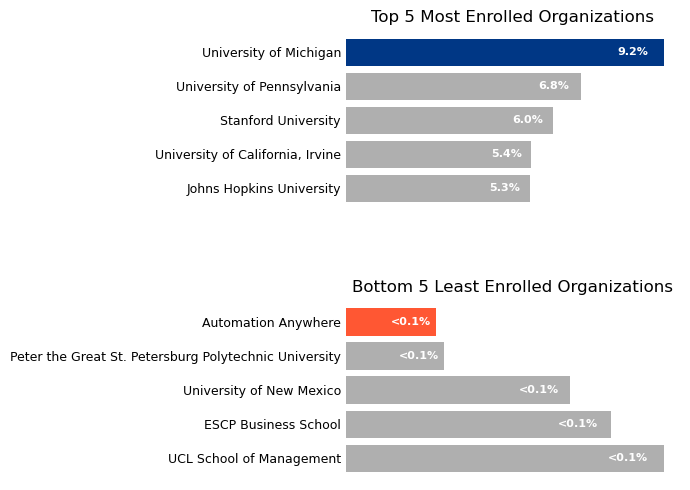

In [47]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), gridspec_kw={"height_ratios": [1, 1]})

plot_enrolled_bar(ax1, top_organizations, "Top 5 Most Enrolled Organizations", "organization", 0, "#003785")
plot_enrolled_bar(ax2, bottom_organizations, "Bottom 5 Least Enrolled Organizations", "organization", 0, "#FF5733")

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

#### Insights

- **Top U.S. Universities Lead**, reflecting learner trust in established academic institutions.
- **University of Michigan** contributes the most: **9.2%** of total enrollments.
- Concentration of Influence: Just **5 out of 154 organizations (3.25%)** account for **32.7% of all enrollments**.
- Sharp Popularity Gap: In contrast, the bottom 5 organizations each attract less than 0.1% of enrollments.

---

#### 3.2.5. Top 10 organizations performance metrics

In [48]:
# Identify top 10 organizations by total enrollment and calculate their performance metrics
organization_performance = df_coursera[
    df_coursera["organization"].isin(
        df_coursera.groupby("organization")["students_enrolled"].sum()
        .nlargest(10).index
    )
].groupby("organization").agg(
    Total_Enrol=("students_enrolled", "sum"),
    Avg_Enrol_Per_Course=("students_enrolled", "mean"),
    Avg_Rating=("rating", "mean"),
    Course_Count=("organization", "count")
).reset_index().sort_values(by=["Total_Enrol"], ascending=[False])

In [49]:
# Prepare data for heatmap
df_numeric_for_heatmap = organization_performance.set_index(
    "organization"
).select_dtypes(include=[np.number])

scaler = MinMaxScaler()
df_normalized = pd.DataFrame(
    scaler.fit_transform(df_numeric_for_heatmap),
    columns=["Total Enrollment", "Avg Enrollment", "Avg Rating", "Count Course"],
    index=df_numeric_for_heatmap.index,
)

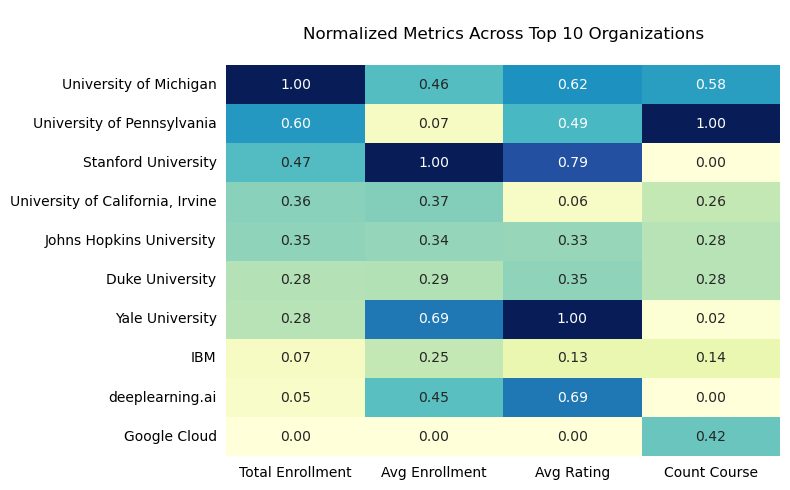

In [50]:
# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df_normalized, annot=True, cmap="YlGnBu", fmt=".2f", cbar=False)

plt.title("\nNormalized Metrics Across Top 10 Organizations\n")
plt.tick_params(axis="x", which="both", bottom=False, top=False)
plt.tick_params(axis="y", which="both", left=False, right=False)
plt.gca().set_ylabel("")

plt.tight_layout()
plt.show()

#### Observations

1. University of Michigan leads in overall performance.
2. **Stanford and Yale excel in per-course impact and quality**.
3. University of Pennsylvania dominates in course quantity.
4. Organizations like IBM and Google Cloud have room to optimize either content quality, reach, or engagement.

---

### 3.3. Analysis by **Difficulty**

#### 3.3.1. Students enrollment by difficulty

In [51]:
rank_difficulty = get_ranked_by_enrollment(df_coursera, column="difficulty", n=4, order="top")
rank_difficulty

,difficulty,students_enrolled,percent_enrolled
1,Beginner,39921800,49.48%
2,Mixed,24989400,30.97%
3,Intermediate,14506300,17.98%
4,Advanced,1264400,1.57%


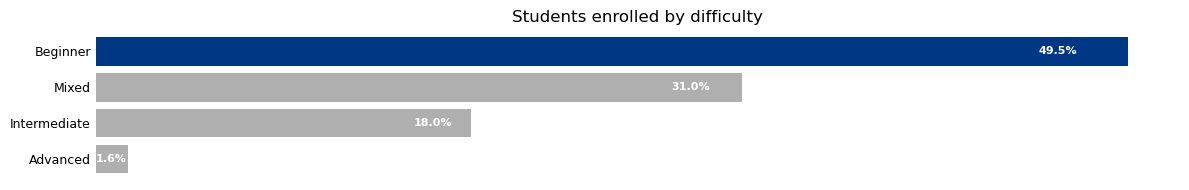

In [52]:
fig, ax1 = plt.subplots(figsize=(12, 2))
plot_enrolled_bar(ax1, rank_difficulty, "Students enrolled by difficulty", "difficulty", 0, "#003785")
plt.tight_layout()
plt.show()

---

#### 3.3.2. Course count by difficulty

In [53]:
difficulty_counts = df_coursera["difficulty"].value_counts()
difficulty_percentages = df_coursera["difficulty"].value_counts(normalize=True) * 100

In [54]:
difficulty_df = pd.DataFrame({
    "difficulty": difficulty_counts.index,
    "count": difficulty_counts.values,
    "pct %": difficulty_percentages.round(2).values
})

In [55]:
difficulty_df

,difficulty,count,pct %
0,Beginner,487,54.66
1,Intermediate,198,22.22
2,Mixed,187,20.99
3,Advanced,19,2.13


#### Insights

- **54.7% of all courses are "Beginner"** level, attracting **49.5% of students** who prefer foundational knowledge or are new to a subject.
- "Mixed" courses account for 31.0% of student enrollment and 20.9% of total offerings.
- Enrollment sharply declines with increasing difficulty: **only 18.0% of students choose Intermediate** courses, and **1.6% opt for Advanced**.

---

### 3.4. Analysis by **Certificate Type**

#### 3.4.1. Students enrollment by certificate type

In [56]:
rank_certificate = get_ranked_by_enrollment(df_coursera, column="certificate_type", n=3, order="top")
rank_certificate

,certificate_type,students_enrolled,percent_enrolled
1,Course,51131300,63.37%
2,Specialization,27262200,33.79%
3,Professional Certificate,2288400,2.84%


#### 3.4.2 Certificate Types: Key Metrics Heatmap

In [57]:
metrics = df_coursera.groupby("certificate_type", observed=False).agg({
    "students_enrolled": ["sum", "mean", "count"],
    "rating": "mean"
})

metrics.columns = ["Total Enrollment", "Average Enrollment", "Course Count", "Average Rating"]
metrics = metrics.reset_index()

scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(metrics.iloc[:, 1:])

# Create DataFrame for the heatmap
df_normalized = pd.DataFrame(
    normalized_values,
    index=metrics["certificate_type"],
    columns=["Total Enrollment", "Avg Enrollment", "Course Count", "Rating"]
)

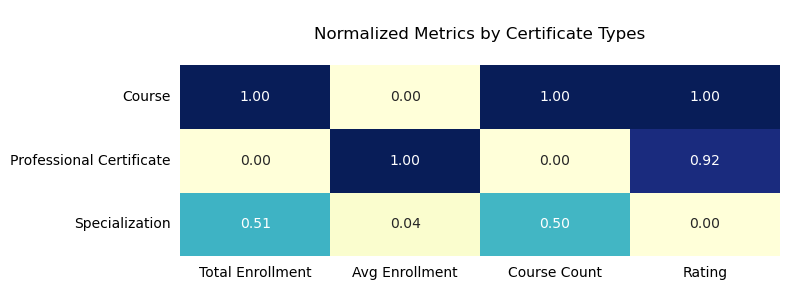

In [58]:
# Plot heatmap
plt.figure(figsize=(8, 3))
sns.heatmap(
    df_normalized,
    annot=True,
    cmap="YlGnBu",
    fmt=".2f",
    cbar=False
)

plt.title("\nNormalized Metrics by Certificate Types\n", fontsize=12)
plt.tick_params(axis="x", bottom=False)
plt.tick_params(axis="y", left=False)
plt.ylabel("")
plt.tight_layout()
plt.show()

#### Insights

- **Courses** Dominate in **Quantity and Popularity**
- **Professional Certificates: Highest Average Enrollment** per course, and a strong Rating. Despite having fewest total enrollments and low course count, they deliver focused, high-impact content.
- **Specializations:** Moderate Total Enrollment and Course Count, but very **low Average Enrollment and Rating**. May reflect less learner engagement per course.

---

### 3.5. Analysis by **Language**

#### 3.5.1. Students enrollment by language

In [59]:
rank_language = get_ranked_by_enrollment(df_coursera, column="language", n=6, order="top")
rank_language

,language,students_enrolled,percent_enrolled
1,en,75846800,94.01%
2,es,3720800,4.61%
3,ru,599800,0.74%
4,fr,357900,0.44%
5,pt,141500,0.18%
6,ja,15100,0.02%


#### Insights

- **English** (en) is the primary language for Coursera enrollments, accounting for **94.01%** of all students.
- Spanish ranks second at 4.61%, far behind English but still the only language with notable representation.
- Low engagement in other languages: Russian, French, Portuguese, and Japanese each account for under 1% of enrollments.


---

### 3.6. Analysis by **Category**

#### 3.6.1. Student enrollement by Category

In [60]:
categories_enrolled = get_ranked_by_enrollment(df_coursera, column="category", n=10, order="top")
categories_enrolled

,category,students_enrolled,percent_enrolled
1,Data Science & Analytics,22915900,28.40%
2,Business & Marketing,12739500,15.79%
3,Other,10448100,12.95%
4,Programming & Software Dev,10384200,12.87%
5,Health & Medicine,7613100,9.44%
6,Arts & Humanities,6021000,7.46%
7,Personal Development,4877600,6.05%
8,Cloud Computing & IT,3965100,4.91%
9,Social Sciences,953400,1.18%
10,Mathematics & Logic,764000,0.95%


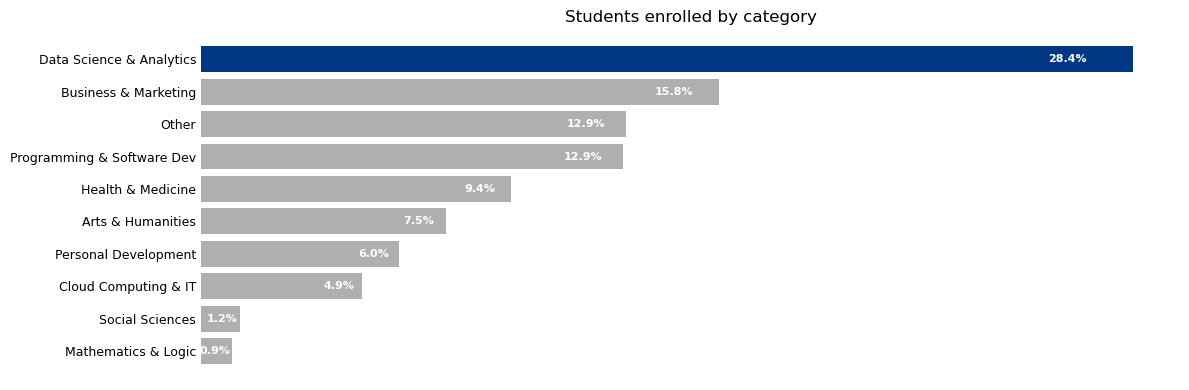

In [61]:
fig, ax1 = plt.subplots(figsize=(12, 4))
plot_enrolled_bar(ax1, categories_enrolled, "Students enrolled by category", "category", 0, "#003785")
plt.tight_layout()
plt.show()

#### Insights

- **Data Science & Analytics** is the most popular category, capturing **28.44%** of all student enrollments (nearly 23 million students).
- "Business & Marketing" (15.8%) and "Programming & Software Dev" (12.9%) are the next most popular categories. When combined with "Cloud Computing & IT" (4.9%), it's clear that professional, tech-oriented skills are the primary drivers of enrollment on Coursera.
- Traditional academic fields like "Social Sciences" (1.2%) and "Mathematics & Logic" (0.9%) have the lowest enrollments. 

---

#### 3.6.2. Most common keywords in title by Category

- TF-IDF keyword extraction
- Aggregation of keyword metrics

In [62]:
df_topic = df_coursera.copy()

In [63]:
# Clean titles for TF-IDF
df_topic["clean_title"] = df_topic["translated_title"].apply(
    lambda x: re.sub(r"[^a-zA-Z\s]", "", str(x).lower())
)

In [64]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_features=500)

categories = df_topic["category"].unique()
category_figures = []

In [65]:
for cat in categories:
    df_cat = df_topic[df_topic["category"] == cat].copy()
    
    if df_cat.empty or df_cat["clean_title"].nunique() < 2:
        continue
    
    # TF-IDF processing
    tfidf_matrix = vectorizer.fit_transform(df_cat["clean_title"])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    
    # Top keyword per course
    df_cat["top_keyword"] = tfidf_df.idxmax(axis=1)
    
    keyword_metrics = df_cat.groupby("top_keyword").agg(
        Average_Enrollment=("students_enrolled", "mean"),
        Average_Rating=("rating", "mean"),
        Course_Count=("translated_title", "count")
    ).sort_values(by="Average_Enrollment", ascending=False)

    keyword_metrics = keyword_metrics.round(2)
    
    # Add total TF-IDF score
    total_tfidf_scores = tfidf_df.sum(axis=0)
    total_tfidf_scores_df = total_tfidf_scores.reset_index()
    total_tfidf_scores_df.columns = ["top_keyword", "Total_TFIDF_Score"]
    
    keyword_metrics = pd.merge(
        keyword_metrics.reset_index(),
        total_tfidf_scores_df,
        on="top_keyword",
        how="left"
    ).sort_values(by="Average_Enrollment", ascending=False)
    
    category_figures.append(keyword_metrics.head(20))

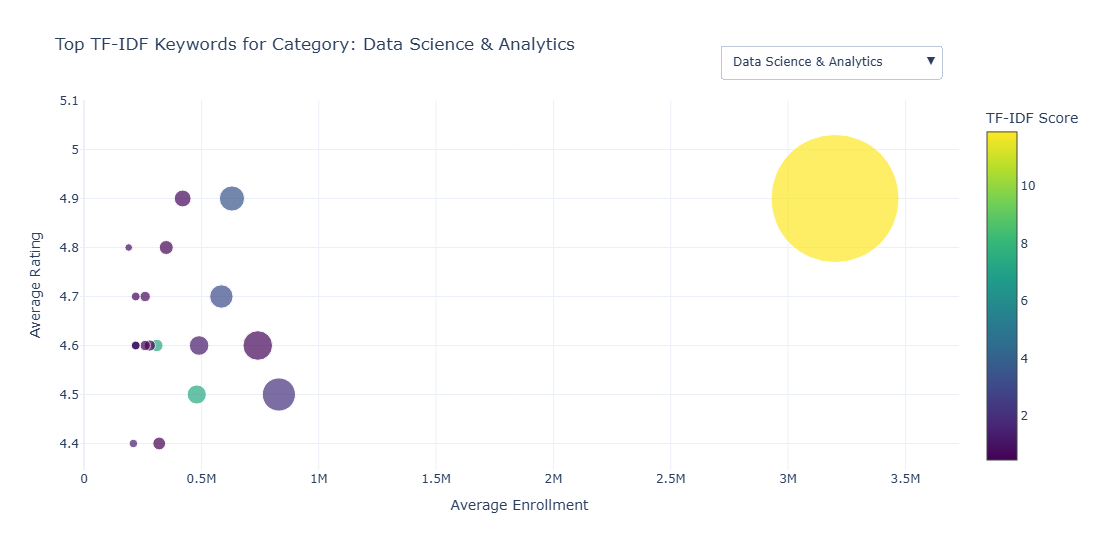

In [66]:
# Create scatter traces for each category
fig = go.Figure()

for i, data in enumerate(category_figures):
    visible = True if i == 0 else False
    fig.add_trace(go.Scatter(
        x=data["Average_Enrollment"],
        y=data["Average_Rating"],
        mode='markers',
        marker=dict(
            size=data["Average_Enrollment"] / 25000,
            color=data["Total_TFIDF_Score"],
            colorscale='Viridis',
            showscale=(i == 0),
            colorbar=dict(title="TF-IDF Score")
        ),
        text=data["top_keyword"],
        customdata=data[["Course_Count", "Total_TFIDF_Score"]],
        hovertemplate=(
            "Keyword: %{text}<br>" +
            "Enrollment: %{x}<br>" +
            "Rating: %{y}<br>" +
            "Courses: %{customdata[0]}<br>" +
            "TF-IDF Score: %{customdata[1]:.2f}<extra></extra>"
        ),
        name=categories[i],
        visible=visible
    ))

dropdown_buttons = [
    dict(label=cat,
         method="update",
         args=[{"visible": [i == j for j in range(len(categories))]},
               {"title": f"Top TF-IDF Keywords for Category: {cat}"}])
    for i, cat in enumerate(categories)
]

fig.update_layout(
    title=f"Top TF-IDF Keywords for Category: {categories[0]}",
    xaxis_title="Average Enrollment",
    yaxis_title="Average Rating",
    width=950,
    height=550,
    template="plotly_white",
    updatemenus=[{
        "buttons": dropdown_buttons,
        "direction": "down",
        "showactive": True,
        "x": 0.98,
        "xanchor": "right",
        "y": 1.15,
        "yanchor": "top"
    }]
)

fig.show()

#### Observations

Keywords with higher TF-IDF scores are more distinctive within their categories and can significantly drive learner engagement. The following keywords stand out due to their uniqueness and high enrollment:

- **"science"** - The most distinctive keyword in *Data Science & Analytics* and across all categories, with the highest average enrollment of **3.2M**.
- **"introduction"** - in *Health & Medicine* with 2.5M.
- **"engineering"** - in *Programming & Software Development* with 1.5M.
- **"security"** - in *Cloud Computing & IT* with 350k.
- **"strategy**" - in *Business & Marketing* with 200k.

---

## 4. Correlation Analysis

Correlation between ***'rating'*** and ***'students_enrolled'***

In [67]:
print(df_coursera[["rating", "students_enrolled"]].corr())

                    rating  students_enrolled
rating             1.00000            0.07109
students_enrolled  0.07109            1.00000


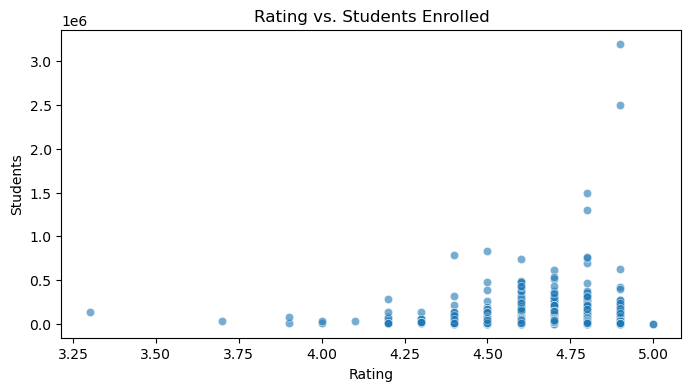

In [68]:
# Plot Scatterplot
plt.figure(figsize=(8, 4))
sns.scatterplot(data=df_coursera, x="rating", y="students_enrolled", alpha=0.6)
plt.title("Rating vs. Students Enrolled")
plt.xlabel("Rating")
plt.ylabel("Students")
plt.show()

#### Insights

- The correlation coefficient between *'rating'* and *'students_enrolled'* is very low (0.071), suggesting no meaningful linear relationship between a course's rating and the number of students it enrolls.
- **High ratings don't guarantee high enrollment**, and moderate ratings can still attract many students.

---

## 5. Statistical Test

Is There a Difference in Average Ratings Across Difficulty Levels?

#### 5.1. Distribution of Course Ratings for each Difficulty level 

In [69]:
difficulty_levels = df_coursera["difficulty"].unique()

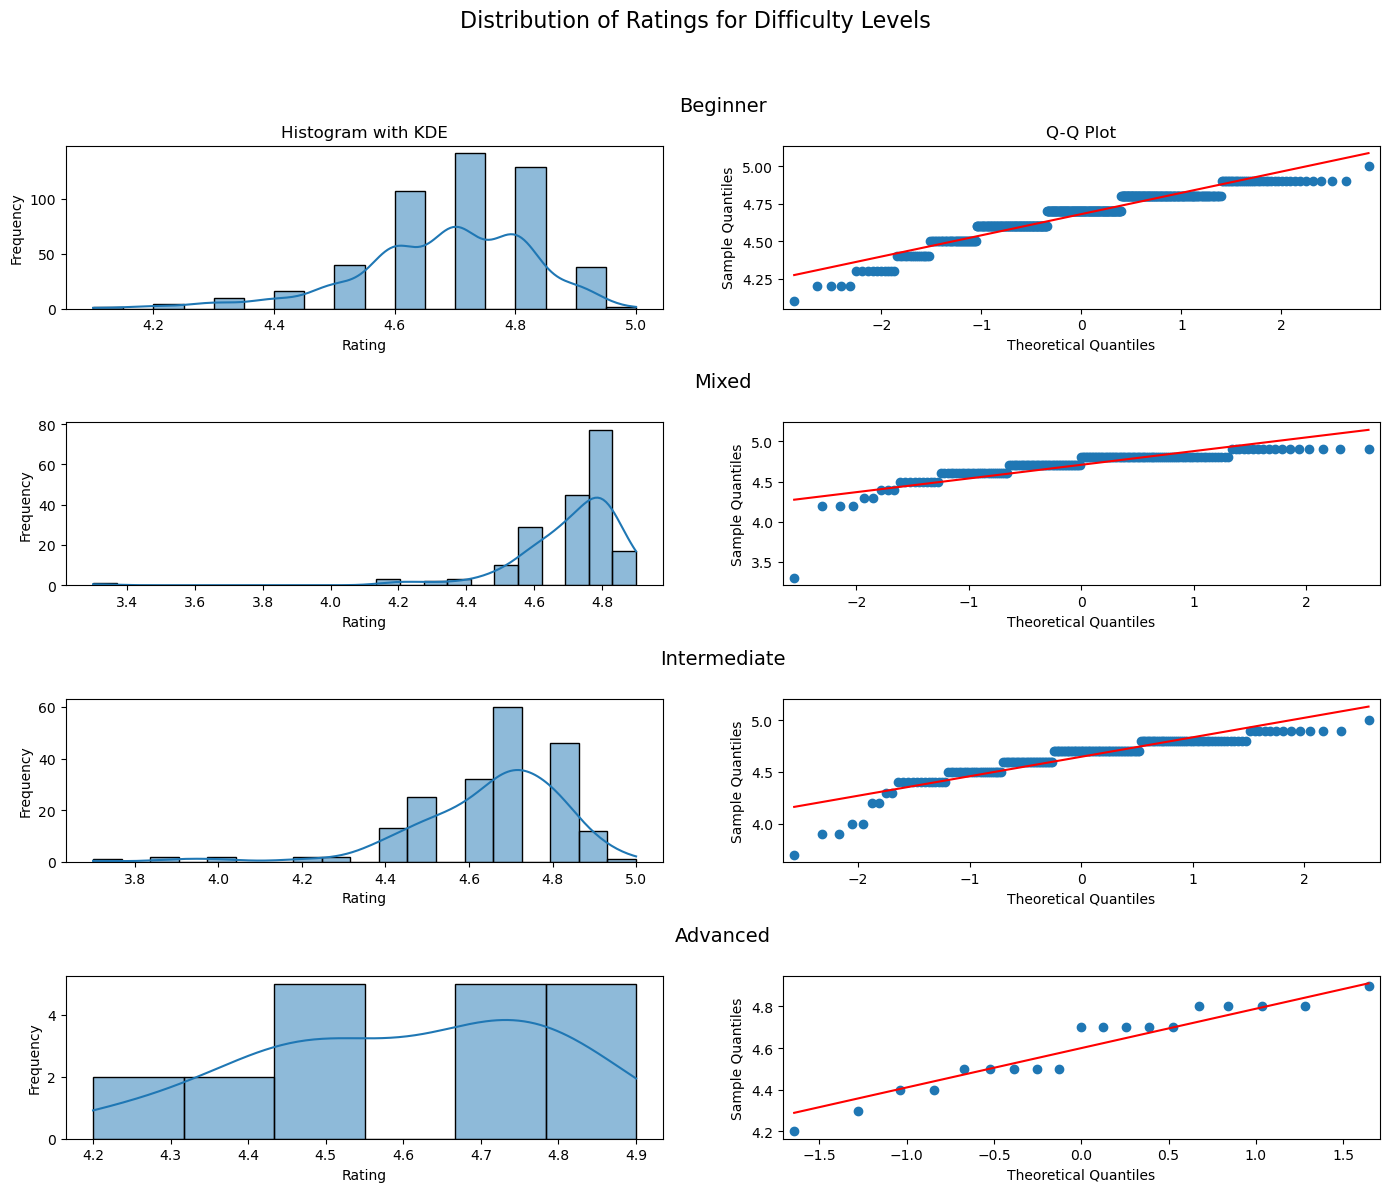

In [70]:
fig_overall, axes_overall = plt.subplots(
    len(difficulty_levels), 2, figsize=(14, 3 * len(difficulty_levels))
)
fig_overall.suptitle(
    "Distribution of Ratings for Difficulty Levels", fontsize=16, y=1.02
)

for i, level in enumerate(difficulty_levels):
    ratings_for_level = df_coursera[df_coursera["difficulty"] == level]["rating"]

    # Plot Histogram
    sns.histplot(ratings_for_level, kde=True, ax=axes_overall[i, 0])
    axes_overall[i, 0].set_xlabel("Rating")
    axes_overall[i, 0].set_ylabel("Frequency")

    # Plot Q-Q Plot
    sm.qqplot(ratings_for_level, line="s", ax=axes_overall[i, 1])
    axes_overall[i, 1].set_ylabel("Sample Quantiles")
    axes_overall[i, 1].set_xlabel("Theoretical Quantiles")

    if i == 0:
        axes_overall[i, 0].set_title("Histogram with KDE")
        axes_overall[i, 1].set_title("Q-Q Plot")
    else:
        axes_overall[i, 0].set_title("")
        axes_overall[i, 1].set_title("")

    axes_overall[i, 0].text(
        1.1,
        1.25,
        f"{level}",
        transform=axes_overall[i, 0].transAxes,
        fontsize=14,
        ha="center",
        va="center",
    )


plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.subplots_adjust(wspace=0.2, hspace=0.7)
plt.show()

#### Insights

- **Q-Q Plots Indicate Deviations from Normality**: While the Q-Q plots show a general linear trend, there are clear deviations, especially at the tails.
- This indicates that the rating distributions are likely not perfectly normal. There's often a "heavier tail" on the lower end, meaning more lower ratings than a normal distribution would predict, and potentially a "lighter tail" on the higher end.

#### 5.1. Shapiro-Wilk Normality Test

- Null Hypothesis **(H0): The data is normally distributed.**
- Alternative Hypothesis **(H1): The data is NOT normally distributed.**

In [71]:
normality_results = {}

for level in difficulty_levels:
    ratings_for_level = df_coursera[df_coursera["difficulty"] == level]["rating"]

    if len(ratings_for_level) >= 3:
        stat, p = stats.shapiro(ratings_for_level)
        normality_results[level] = {
            "Statistic": stat,
            "P-value": p,
            "Count": len(ratings_for_level),
        }
        print(f"Difficulty: {level}")
        print(f"  Shapiro-Wilk Test Statistic: {stat:.3f}")
        print(f"  P-value: {p:.18f}")
        if p > 0.01:
            print("  Result: Fail to reject H0, ratings for this difficulty level appear normally distributed.")
        else:
            print("  Result: Reject H0, ratings for this difficulty level do NOT appear normally distributed.")
        print("-" * 30)

Difficulty: Beginner
  Shapiro-Wilk Test Statistic: 0.916
  P-value: 0.000000000000000737
  Result: Reject H0, ratings for this difficulty level do NOT appear normally distributed.
------------------------------
Difficulty: Mixed
  Shapiro-Wilk Test Statistic: 0.702
  P-value: 0.000000000000000005
  Result: Reject H0, ratings for this difficulty level do NOT appear normally distributed.
------------------------------
Difficulty: Intermediate
  Shapiro-Wilk Test Statistic: 0.846
  P-value: 0.000000000000340356
  Result: Reject H0, ratings for this difficulty level do NOT appear normally distributed.
------------------------------
Difficulty: Advanced
  Shapiro-Wilk Test Statistic: 0.928
  P-value: 0.161646033344948092
  Result: Fail to reject H0, ratings for this difficulty level appear normally distributed.
------------------------------


#### Insight

- While visually these distributions appear quite close to normal, Shapiro-Wilk tests concluded that these **distributions are not statistically normal**.

---

#### 5.2. Kruskal-Wallis H-Test

- Decision is to use a non-parametric Kruskal-Wallis Test due to its independence from normality assumptions and effectiveness with diverse distributions and unequal group sizes.
- ***'Advanced'*** difficulty was **excluded** (due to insufficient sample size  (19) for reliable statistical comparison).

For the Kruskal-Wallis H-Test on **Rating by Difficulty, the hypotheses**:
- Null Hypothesis **(H0): There is no statistically significant difference in the median ratings** across the different course difficulty levels (Beginner, Intermediate, Mixed).
- Alternative Hypothesis **(H1): There is a statistically significant difference in the median ratings** among at least one pair of course difficulty levels.

In [72]:
# Separate the 'rating' data for each specified difficulty level.
beginner_ratings = df_coursera[df_coursera["difficulty"] == "Beginner"]["rating"].values
intermediate_ratings = df_coursera[df_coursera["difficulty"] == "Intermediate"]["rating"].values
mixed_ratings = df_coursera[df_coursera["difficulty"] == "Mixed"]["rating"].values

groups_for_kruskal = [
    beginner_ratings,
    intermediate_ratings,
    mixed_ratings
]

In [73]:
# Perform the Kruskal-Wallis H-test
h_statistic, p_value = stats.kruskal(*groups_for_kruskal)

print(f"--- Kruskal-Wallis H-Test Results for Rating by Difficulty ---")
print(f"H-statistic: {h_statistic:.3f}")
print(f"P-value: {p_value:.6f}")

# Interpret the results
if p_value < 0.01:
    print("\nResult: Reject the null hypothesis.")
    print("There is a statistically significant difference in the median ratings across at least one pair of difficulty levels.")
else:
    print("\nResult: Fail to reject the null hypothesis.")
    print("There is no statistically significant difference in the median ratings across the difficulty levels.")

--- Kruskal-Wallis H-Test Results for Rating by Difficulty ---
H-statistic: 18.472
P-value: 0.000097

Result: Reject the null hypothesis.
There is a statistically significant difference in the median ratings across at least one pair of difficulty levels.


- Since Kruskal-Wallis test (with p-value=0.01) is **statistically significant**, next step is to perform post-hoc test to identify which specific pairs of difficulty levels have significantly different median ratings.

---

#### 5.3. All Pairwise Mann-Whitney U Tests

- The Pairwise Mann-Whitney U Test is used to identify specific pairs of difficulty levels that have significantly different median ratings.
- It doesn't assume that data is normally distributed, nor does it require equal variances between groups.
- It performs individual comparisons between every possible pair of groups.

In [74]:
levels = ["Beginner", "Intermediate", "Mixed"]

# Organize ratings by selected difficulty levels
ratings = {
    level: df_coursera[df_coursera["difficulty"] == level]["rating"].values
    for level in sorted(levels)
}

In [75]:
# Perform pairwise Mann-Whitney U tests
pairwise_results = []
for level1, level2 in itertools.combinations(ratings, 2):
    data1 = ratings[level1]
    data2 = ratings[level2]

    stat, p_value = stats.mannwhitneyu(data1, data2, alternative="two-sided")
    pairwise_results.append({
        "Group1": level1,
        "Group2": level2,
        "MannWhitney_U_Stat": stat,
        "P_value_unadjusted": p_value
    })

pairwise_df = pd.DataFrame(pairwise_results)

In [76]:
print("--- Unadjusted Pairwise Mann-Whitney U Test Results ---")
pairwise_df

--- Unadjusted Pairwise Mann-Whitney U Test Results ---


,Group1,Group2,MannWhitney_U_Stat,P_value_unadjusted
0,Beginner,Intermediate,52200.5,0.081201
1,Beginner,Mixed,38199.5,0.000837
2,Intermediate,Mixed,14147.5,0.000038


---

#### 5.4. Apply Bonferroni Correction for Multiple Comparisons

- Performing multiple statistical tests inflates the Type I error rate (false positives).
- Bonferroni correction adjusts p-values across these simultaneous tests to control the family-wise error rate, ensuring the overall probability of a false positive remains at the desired significance level (e.g., 0.01).

In [77]:
unadjusted_p_values = pairwise_df["P_value_unadjusted"].tolist()

# Apply Bonferroni correction
reject_bonf, p_values_bonf_corrected, alpha_bonf_corrected, alpha_bonf_unadjusted = multipletests(
    unadjusted_p_values,
    alpha=0.01,
    method="bonferroni"
)

pairwise_df["P_value_bonferroni_corrected"] = p_values_bonf_corrected
pairwise_df["Significant_bonferroni"] = reject_bonf

In [78]:
print("\n--- Adjusted Pairwise Mann-Whitney U Test Results (Bonferroni Correction) ---")
pairwise_df


--- Adjusted Pairwise Mann-Whitney U Test Results (Bonferroni Correction) ---


,Group1,Group2,MannWhitney_U_Stat,P_value_unadjusted,P_value_bonferroni_corrected,Significant_bonferroni
0,Beginner,Intermediate,52200.5,0.081201,0.243604,False
1,Beginner,Mixed,38199.5,0.000837,0.002511,True
2,Intermediate,Mixed,14147.5,0.000038,0.000113,True


- Results suggest that **users rate the Mixed difficulty level differently** than both Beginner and Intermediate levels.

In [79]:
df_coursera.groupby("difficulty", observed=False)["rating"].median()

difficulty
Advanced        4.7
Beginner        4.7
Intermediate    4.7
Mixed           4.8
Name: rating, dtype: float64

#### Insights

- While a numerical difference of **0.1** (from 4.7 to 4.8) may seem minor, its **statistical significance** confirms it's unlikely to be due to random chance.
- Even a seemingly small 0.1 point difference in median ratings, particularly on a 5-point scale, can be highly meaningful. It not only influences course selection but also suggests that learners may perceive *'Mixed'* difficulty courses more positively than either *'Beginner'* or *'Intermediate'*.